In [55]:
%config IPCompleter.use_jedi=False

import numpy as np
import pandas as pd
from scipy.spatial import distance
from matplotlib import pyplot as plt
import seaborn as sns
import vccfcoords
from vccfcoords import simulation
from vccfcoords import utils
from vccfcoords import solvers
import math
import localization as lx
import os, sys
from typing import Dict, Any, Tuple, List, Union
import hashlib
import json
from importlib import reload
from tqdm import tqdm
reload(vccfcoords.simulation)
reload(vccfcoords.utils)
reload(vccfcoords.solvers)

<module 'vccfcoords.solvers' from '/workspaces/vccfcoords/vccfcoords/solvers.py'>

In [2]:
testing_solver = simulation.sim_coordinates(5, 3, -5,5)
print(testing_solver)
distances = [utils.get_euclid_dist(testing_solver[0],x) for x in testing_solver[1:]]
computed_coords = solvers.geom_3D_solver(distances, testing_solver[1:])
print(computed_coords)

[[-3.9767762  -0.49137944  2.9764349 ]
 [-4.2011125   4.32536936  1.87714204]
 [-2.66644789 -3.03017556  0.93597328]
 [ 0.26069705 -2.62790414 -0.37978428]
 [-1.42126795 -3.5231409   2.38898443]]
(-3.976776202504399, -0.49137944076325624, 2.9764348970480445)


In [53]:
def check_lse_2d_sign():
    n_checks = 10000

    euclid_error = []
    for i in range(n_checks):
        sim_points = simulation.sim_coordinates(8, 2, -5,5)
        distances = [utils.get_euclid_dist(sim_points[0],x) for x in sim_points[1:]]
        x,y = solvers.opt_lse_2D_solver(distances, sim_points[1:])

        #assert(np.sign(x) == np.sign(sim_points[0][0]))
        #assert(np.sign(y) == np.sign(sim_points[0][1]))

        euclid_error.append(utils.get_euclid_dist((x,y), tuple(sim_points[0])))
    
    return np.mean(euclid_error)

In [82]:
def check_lse_3D_sign():
    n_checks = 10000

    euclid_error = []
    for i in range(n_checks):
        sim_points = simulation.sim_coordinates(9, 3, -5,5)
        distances = [utils.get_euclid_dist(sim_points[0],x) for x in sim_points[1:]]
        x,y,z = solvers.opt_lse_3D_solver(distances, sim_points[1:])

        assert(np.sign(x) == np.sign(sim_points[0][0]))
        assert(np.sign(y) == np.sign(sim_points[0][1]))

        euclid_error.append(utils.get_euclid_dist((x,y,z), tuple(sim_points[0])))
    
    return np.mean(euclid_error)

In [83]:
check_lse_3D_sign()

1.0047984086562821e-15

In [26]:
check_2d_sign()

3.253756813633929e-14

In [27]:
def check_2d_sign():
    n_checks = 1000

    euclid_error = []
    for i in range(n_checks):
        sim_points = simulation.sim_coordinates(4, 2, -5,5)
        distances = [utils.get_euclid_dist(sim_points[0],x) for x in sim_points[1:]]
        x,y = solvers.geom_2D_solver(distances, sim_points[1:])

        assert(np.sign(x) == np.sign(sim_points[0][0]))
        assert(np.sign(y) == np.sign(sim_points[0][1]))

        euclid_error.append(utils.get_euclid_dist((x,y), tuple(sim_points[0])))
    
    return np.mean(euclid_error)

def check_3d_sign():
    n_checks = 1000

    euclid_error = []
    for i in range(n_checks):
        sim_points = simulation.sim_coordinates(5, 3, -5,5)


        distances = [utils.get_euclid_dist(sim_points[0],x) for x in sim_points[1:]]
        x,y,z = solvers.geom_3D_solver(distances, sim_points[1:])

        assert(np.sign(x) == np.sign(sim_points[0][0]))
        assert(np.sign(y) == np.sign(sim_points[0][1]))
        assert(np.sign(z) == np.sign(sim_points[0][2]))

        euclid_error.append(utils.get_euclid_dist((x,y,z), tuple(sim_points[0])))

    
    return np.mean(euclid_error)

#print(check_2d_sign())
#print(check_3d_sign())

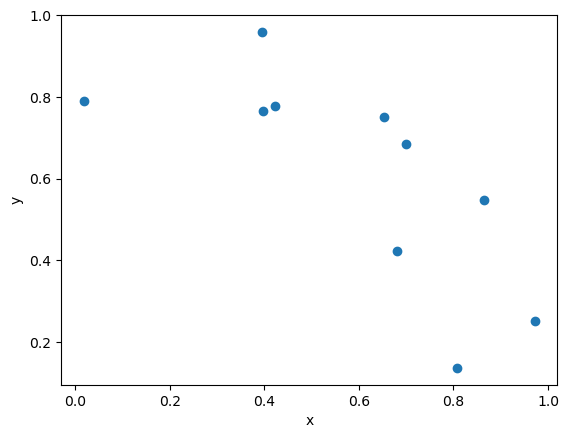

In [22]:
test_coords = simulation.sim_coordinates(10, 3, 0,1)
test_closet_points = simulation.get_closest_points(test, (0,0,0), 5)
utils.plot_coordinates(test_coords, 2)


In [14]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def estimate_coord(coords, distances):
    
    dim = coords.shape[1]
    dim_str = str(dim) + "D"

    state = lx.Project(mode=dim_str,solver='LSE')

    for coord_idx in range(len(coords)):
        state.add_anchor(str(coord_idx), tuple(coords[coord_idx]))
    
    unknown_cell, unkown_cell_label= state.add_target()

    for dist_idx in range(len(distances)):
        unknown_cell.add_measure(str(dist_idx),distances[dist_idx])

    with HiddenPrints():
        state.solve()

    computed_coord = None

    if dim == 2:
        computed_coord = np.array((unknown_cell.loc.x, unknown_cell.loc.y))
    else:
        computed_coord = np.array((unknown_cell.loc.x, unknown_cell.loc.y, unknown_cell.loc.z))

    return computed_coord


def estimate_coords(EC_coords, closest_cells_dict):

    COORD_IDX = 0
    DIST_IDX = 1

    computed_coords = dict()

    for key,val in closest_cells_dict.items():
        reference_coords = EC_coords[val[COORD_IDX]]
        reference_dists = val[DIST_IDX]

        computed_coord = estimate_coord(reference_coords, reference_dists)

        computed_coords[key] = computed_coord

    return computed_coords

def get_avg_dist_error(true_coords, pred_coords_dict):

    dist_error = [get_euclid_dist(true_coords[x], pred_coords_dict[x]) for x in pred_coords_dict]

    return np.mean(dist_error)

def run_simulation(n_EC,
                   n_other_cells,
                   n_dim,
                   n_closest,
                   coord_min,
                   coord_max,
                   seed):
    
    COORD_IDX = 0
    DIST_IDX = 1

    np.random.seed(seed)
    
    #Generating Coordinates
    EC_coords = sim_coordinates(n_EC, n_dim, coord_min, coord_max)
    other_cell_coords = sim_coordinates(n_other_cells, n_dim, coord_min, coord_max)

    simulated_coords_hash = hash(np.vstack((EC_coords, other_cell_coords)).tobytes())

    n_closest_list = n_closest if isinstance(n_closest, list) else [n_closest]

    closest_EC_cells_dict = {x:get_closest_points(EC_coords,other_cell_coords[x], n_other_cells) for x in list(range(len(other_cell_coords)))}

    avg_dist_error_list = []

    #Using Multilateration engine to estimate coordinates given distances to endothelial cells
    for n_closest_num in n_closest_list:
        closest_EC_cells_dict_subset = {x:(y[COORD_IDX][:n_closest_num],y[DIST_IDX][:n_closest_num]) for x,y in closest_EC_cells_dict.items()}
        computed_coords = estimate_coords(EC_coords, closest_EC_cells_dict_subset)
        avg_dist_error = get_avg_dist_error(other_cell_coords, computed_coords)

        avg_dist_error_list.append(avg_dist_error)

    experiment_dict_list = []

    for x,y in zip(n_closest_list, avg_dist_error_list):
        experiment_dict = dict()
        experiment_dict["seed"] = seed
        experiment_dict["simulated_coords_hash"] = simulated_coords_hash
        experiment_dict["n_EC"] = n_EC
        experiment_dict["n_other_cells"] = n_other_cells
        experiment_dict["n_dim"] = n_dim
        experiment_dict["coord_min"] = coord_min
        experiment_dict["coord_max"] = coord_max
        experiment_dict["n_closest"] = x
        experiment_dict["avg_dist_error"] = y

        experiment_dict_list.append(experiment_dict)

    return experiment_dict_list

In [40]:
resp = [run_simulation(n_EC=1000,
               n_other_cells=10000,
               n_dim=3,
               n_closest=[2,3,4,5,6,7,8,9,10],
               coord_min = -1,
               coord_max = 1,
               seed = x) for x in tqdm(list(range(10)))]

100%|██████████| 10/10 [35:59<00:00, 215.98s/it]


In [44]:
large_run_df = pd.concat([pd.DataFrame(x)for x in resp], axis = 0)

Text(0.5, 1.0, 'Error Between Simulated And Estimated \nCoords of Non-EC Cells\n\n 10 runs per bar, 1k EC cells, 10k Non-EC cells, \nCoords Range: [-1,1], 3 dimensions, 35 min runtime')

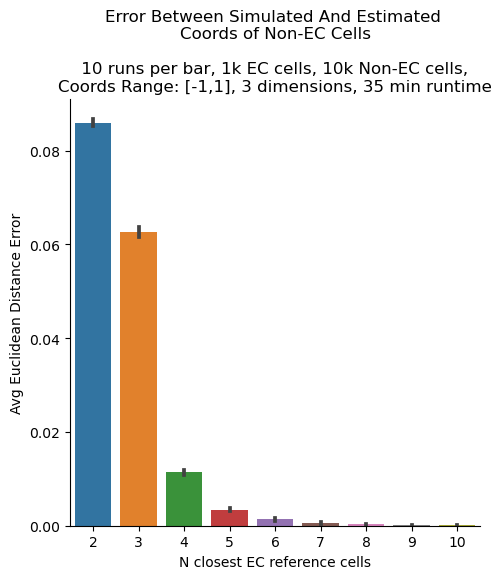

In [84]:
sns.catplot(large_run_df, x="n_closest", y="avg_dist_error", kind="bar")
plt.xlabel("N closest EC reference cells")
plt.ylabel("Avg Euclidean Distance Error")
plt.title("Error Between Simulated And Estimated \nCoords of Non-EC Cells\n\n 10 runs per bar, 1k EC cells, 10k Non-EC cells, \nCoords Range: [-1,1], 3 dimensions, 35 min runtime")

In [79]:
large_run_df.groupby("n_closest").apply(lambda x: np.mean(x.avg_dist_error))

n_closest
2     0.085977
3     0.062651
4     0.011401
5     0.003443
6     0.001331
7     0.000619
8     0.000277
9     0.000102
10    0.000065
dtype: float64

In [81]:
large_run_df.groupby("n_closest").apply(lambda x: np.std(x.avg_dist_error))

n_closest
2     0.001083
3     0.001834
4     0.000974
5     0.000556
6     0.000396
7     0.000290
8     0.000161
9     0.000098
10    0.000082
dtype: float64

In [50]:
sim_coordinates(10, 3, 0, 1)

array([[0.52065432, 0.35658553, 0.39339387],
       [0.96057251, 0.70959679, 0.32454496],
       [0.09043209, 0.33665985, 0.95246023],
       [0.65269004, 0.47009769, 0.94798631],
       [0.99025935, 0.57875414, 0.21326749],
       [0.0158442 , 0.95190278, 0.33178007],
       [0.35298317, 0.18044788, 0.37049409],
       [0.90084386, 0.37752673, 0.90300179],
       [0.43690985, 0.09410114, 0.67609426],
       [0.50241853, 0.52232688, 0.8118764 ]])

In [51]:
np.array([(0,0,0), (1,1,1)])

array([[0, 0, 0],
       [1, 1, 1]])

In [14]:
resp = run_simulation(n_EC=1000,
               n_other_cells=1000,
               n_dim=2,
               n_closest=[2,3,4,5,6,7,8,9,10],
               coord_min = -1,
               coord_max = 1)

In [37]:
pd.DataFrame(resp)

,seed,simulated_coords_hash,n_EC,n_other_cells,n_dim,coord_min,coord_max,n_closest,avg_dist_error
0,0,7587821444061547715,10,10,3,-1,1,2,5.086207e-01
1,0,7587821444061547715,10,10,3,-1,1,3,3.911569e-01
2,0,7587821444061547715,10,10,3,-1,1,4,4.650563e-02
3,0,7587821444061547715,10,10,3,-1,1,5,4.134664e-02
4,0,7587821444061547715,10,10,3,-1,1,6,1.146340e-06
5,0,7587821444061547715,10,10,3,-1,1,7,5.482760e-07
6,0,7587821444061547715,10,10,3,-1,1,8,9.024588e-07
7,0,7587821444061547715,10,10,3,-1,1,9,3.679568e-07
8,0,7587821444061547715,10,10,3,-1,1,10,3.829499e-07


In [167]:
#Generating Cell Coordinates
EC_coords = sim_coordinates(1000, 3, -1, 1)
other_cell_coords = sim_coordinates(10000, 3, -1, 1)

#Computing Closest Neighbors to Each Cell
closest_EC_cells_3 = {x:get_closest_points(EC_coords,other_cell_coords[x], 1000) for x in list(range(len(other_cell_coords)))}

In [168]:
closest_EC_cells_3[0]

(array([118, 979, 311,  28, 383, 912, 815, 959, 985, 375,  47, 346, 610,
        719, 547,  46,  10, 362, 370, 417, 570, 758, 653,  24, 972,  23,
        671,  66, 457, 127, 939, 802, 980, 905, 165,  50, 195, 548, 861,
        870, 339, 343, 625,  17, 924, 431, 893, 849, 327, 934, 317, 799,
         89,  92, 476, 760, 803, 842, 712, 545, 214, 356, 401, 779, 501,
        933, 409, 656, 742, 427, 752, 300,  43, 753, 452, 876, 105, 602,
        527, 146, 890, 832, 553, 560, 761, 885, 407, 286, 633, 860, 620,
        836, 155, 133, 884, 613, 728, 180, 571, 871, 952, 643, 378, 735,
        634, 695, 999, 134, 510,  65, 148, 675, 497, 998, 906, 929,  13,
        528,  15,  53, 581, 413, 516, 917, 411, 416, 273, 563, 679, 647,
        654, 491, 838,  29, 766, 883, 850, 194, 853,  39, 635, 358, 833,
        935, 822, 137, 301,  76, 493, 359,   0, 579, 402,  75,  32,  26,
        556, 992, 477, 326,  36, 429,  63, 851, 349, 275, 572, 823, 216,
        968, 796, 987, 307, 726, 805, 751, 966, 104

In [8]:
np.random.seed(0)

In [32]:
np.random.seed(99999)
hash(sim_coordinates(11, 3, 0, 1).tobytes())

4443880115439545674